# Simulating gate noise on the Rigetti Quantum Virtual Machine
© Copyright 2017, Rigetti Computing. 
$$
\newcommand{ket}[1]{\left|{#1}\right\rangle}
\newcommand{bra}[1]{\left\langle {#1}\right|}
\newcommand{tr}{\mathrm{Tr}}
$$

## Pure states vs. mixed states


Errors in quantum computing can introduce classical uncertainty in what the underlying state is.
When this happens we sometimes need to consider not only wavefunctions but also probabilistic sums of
wavefunctions when we are uncertain as to which one we have. For example, if we think that an X gate
was accidentally applied to a qubit with a 50-50 chance then we would say that there is a 50% chance
we have the $\ket{0}$ state and a 50% chance that we have a $\ket{1}$ state.
This is called an "impure" or
"mixed"state in that it isn't just a wavefunction (which is pure) but instead a distribution over
wavefunctions. We describe this with something called a density matrix, which is generally an
operator. Pure states have very simple density matrices that we can write as an outer product of a
ket vector $\ket{\psi}$ with its own bra version $\bra{\psi}=\ket{\psi}^\dagger$.
For a pure state the density matrix is simply


$$
   \rho_\psi = \ket{\psi}\bra{\psi}.
$$
The expectation value of an operator for a mixed state is given by

$$
   \langle X \rangle_\rho = \tr{X \rho}
$$
where $\tr{A}$ is the trace of an operator, which is the sum of its diagonal elements
which is independent of choice of basis.
Pure state density matrices satisfy

$$
   \rho \text{ is pure } \Leftrightarrow \rho^2 = \rho
$$
which you can easily verify for $\rho_\psi$ assuming that the state is normalized.
If we want to describe a situation with classical uncertainty between states $\rho_1$ and
$\rho_2$, then we can take their weighted sum
$$
   \rho = p \rho_1 + (1-p) \rho_2
$$
where $p\in [0,1]$ gives the classical probability that the state is $\rho_1$.

Note that classical uncertainty in the wavefunction is markedly different from superpositions.
We can represent superpositions using wavefunctions, but use density matrices to describe
distributions over wavefunctions. You can read more about density matrices [here](https://en.wikipedia.org/wiki/Density_matrix).

# Quantum gate errors
## What are they?
For a quantum gate given by its unitary operator $U$, a "quantum gate error" describes the scenario in which the actually induces transformation deviates from $\ket{\psi} \mapsto U\ket{\psi}$. 
There are two basic types of quantum gate errors:

1. **coherent errors** are those that preserve the purity of the input state, i.e., instead of the above mapping we carry out a perturbed, but unitary operation $\ket{\psi} \mapsto \tilde{U}\ket{\psi}$, where $\tilde{U} \neq U$.  
2. **incoherent errors** are those that do not preserve the purity of the input state, 
    in this case we must actually represent the evolution in terms of density matrices. 
    The state $\rho := \ket{\psi}\bra{\psi}$ is then mapped as 
    $$
    \rho \mapsto \sum_{j=1}^n K_j\rho K_j^\dagger, 
    $$ 
    where the operators $\{K_1, K_2, \dots, K_m\}$ are called Kraus operators and must obey 
    $\sum_{j=1}^m K_j^\dagger K_j = I$ to conserve the trace of $\rho$. 
    Maps expressed in the above form are called Kraus maps. It can be shown that every physical map on a finite
    dimensional quantum system can be represented as a Kraus map, though this representation is not generally unique.
    [You can find more information about quantum operations here](https://en.wikipedia.org/wiki/Quantum_operation#Kraus_operators)
  
In a way, coherent errors are *in principle* amendable by more precisely calibrated control. Incoherent errors are more tricky.

## Why do incoherent errors happen?
When a quantum system (e.g., the qubits on a quantum processor) is not perfectly isolated from its environment it generally co-evolves with the degrees of freedom it couples to. The implication is that while the total time evolution of system and environment can be assumed to be unitary, restriction to the system state generally is not.

**Let's throw some math at this for clarity:**
Let our total Hilbert space be given by the tensor product of system and environment Hilbert spaces:
$\mathcal{H} = \mathcal{H}_S \otimes \mathcal{H}_E$.
Our system "not being perfectly isolated" must be translated to the statement that the global Hamiltonian contains a contribution that couples the system and environment:
$$
H = H_S \otimes I + I \otimes H_E + V
$$
where $V$ non-trivally acts on both the system and the environment.
Consequently, even if we started in an initial state that factorized over system and environment $\ket{\psi}_{S,0}\otimes \ket{\psi}_{E,0}$
if everything evolves by the Schrödinger equation
$$
\ket{\psi_t} = e^{-i \frac{Ht}{\hbar}} \left(\ket{\psi}_{S,0}\otimes \ket{\psi}_{E,0}\right)
$$
the final state will generally not admit such a factorization.

## A toy model
**In this (somewhat technical) section we show how environment interaction can corrupt an identity gate and derive its Kraus map.**
For simplicity, let us assume that we are in a reference frame in which both the system and environment Hamiltonian's vanish $H_S = 0, H_E = 0$ and where the cross-coupling is small even when multiplied by the duration of the time evolution $\|\frac{tV}{\hbar}\|^2 \sim \epsilon \ll 1$ (any operator norm $\|\cdot\|$ will do here).
Let us further assume that $V = \sqrt{\epsilon} V_S \otimes V_E$ (the more general case is given by a sum of such terms) and that 
the initial environment state satisfies $\bra{\psi}_{E,0} V_E\ket{\psi}_{E,0} = 0$. This turns out to be a very reasonable assumption in practice but a more thorough discussion exceeds our scope.

Then the joint system + environment state $\rho = \rho_{S,0} \otimes \rho_{E,0}$ (now written as a density matrix) evolves as
$$
\rho \mapsto \rho' :=  e^{-i \frac{Vt}{\hbar}} \rho e^{+i \frac{Vt}{\hbar}}
$$
Using the Baker-Campbell-Hausdorff theorem we can expand this to second order in $\epsilon$
$$
\rho' = \rho - \frac{it}{\hbar} [V, \rho] - \frac{t^2}{2\hbar^2} [V, [V, \rho]] + O(\epsilon^{3/2})
$$
We can insert the initially factorizable state $\rho = \rho_{S,0} \otimes \rho_{E,0}$ and trace over the environmental degrees of freedom to obtain
\begin{align}
\rho_S' := \tr_E \rho' & = \rho_{S,0}  \underbrace{\tr \rho_{E,0}}_{1} - \frac{i\sqrt{\epsilon} t}{\hbar} \underbrace{\left[ V_S \rho_{S,0} \underbrace{\tr V_E\rho_{E,0}}_{\bra{\psi}_{E,0} V_E\ket{\psi}_{E,0} = 0} - \rho_{S,0}V_S  \underbrace{\tr \rho_{E,0}V_E}_{\bra{\psi}_{E,0} V_E\ket{\psi}_{E,0} = 0} \right]}_0 \\
& \qquad - \frac{\epsilon t^2}{2\hbar^2} \left[ V_S^2\rho_{S,0}\tr V_E^2 \rho_{E,0} + \rho_{S,0} V_S^2 \tr \rho_{E,0}V_E^2 - 2 V_S\rho_{S,0}V_S\tr V_E \rho_{E,0}V_E\right] \\
& = \rho_{S,0} - \frac{\gamma}{2} \left[ V_S^2\rho_{S,0} + \rho_{S,0} V_S^2  - 2 V_S\rho_{S,0}V_S\right]
\end{align}
where the coefficient in front of the second part is by our initial assumption very small $\gamma := \frac{\epsilon t^2}{2\hbar^2}\tr V_E^2 \rho_{E,0} \ll 1$.
This evolution happens to be approximately equal to a Kraus map with operators $K_1 := I - \frac{\gamma}{2} V_S^2, K_2:= \sqrt{\gamma} V_S$:
\begin{align}
\rho_S \to \rho_S' &= K_1\rho K_1^\dagger + K_2\rho K_2^\dagger
 = \rho - \frac{\gamma}{2}\left[ V_S^2 \rho + \rho V_S^2\right] + \gamma V_S\rho_S V_S + O(\gamma^2)
\end{align}
This agrees to $O(\epsilon^{3/2})$ with the result of our derivation above. This type of derivation can be extended to many other cases with little complication and a very similar argument is used to derive the [Lindblad master equation](https://en.wikipedia.org/wiki/Lindblad_equation).

# Support for noisy gates on the Rigetti QVM

As of today, users of our Forest API can annotate their QUIL programs by certain pragma statements that inform the QVM that a particular gate on specific target qubits should be replaced by an imperfect realization given by a Kraus map.

## But the QVM propagates *pure states*: How does it simulate noisy gates?
It does so by yielding the correct outcomes **in the average over many executions of the QUIL program**:
When the noisy version of a gate should be applied the QVM makes a random choice which Kraus operator is applied to the current state with a probability that ensures that the average over many executions is equivalent to the Kraus map.
In particular, a particular Kraus operator $K_j$ is applied to $\ket{\psi}_S$
$$
\ket{\psi'}_S = \frac{1}{\sqrt{p_j}} K_j \ket{\psi}_S
$$
with probability $p_j:= \bra{\psi}_S K_j^\dagger K_j \ket{\psi}_S$.
In the average over many execution $N \gg 1$ we therefore find that
\begin{align}
\overline{\rho_S'} & = \frac{1}{N} \sum_{n=1}^N \ket{\psi'_n}_S\bra{\psi'_n}_S \\
& = \frac{1}{N} \sum_{n=1}^N p_{j_n}^{-1}K_{j_n}\ket{\psi'}_S \bra{\psi'}_SK_{j_n}^\dagger
\end{align}
where $j_n$ is the chosen Kraus operator label in the $n$-th trial.
This is clearly a Kraus map itself! And we can group identical terms and rewrite it as
\begin{align}
\overline{\rho_S'} & = 
  \sum_{\ell=1}^n \frac{N_\ell}{N}  p_{\ell}^{-1}K_{\ell}\ket{\psi'}_S \bra{\psi'}_SK_{\ell}^\dagger
\end{align}
where $N_{\ell}$ is the number of times that Kraus operator label $\ell$ was selected.
For large enough $N$ we know that $N_{\ell} \approx N p_\ell$ and therefore
\begin{align}
\overline{\rho_S'} \approx \sum_{\ell=1}^n K_{\ell}\ket{\psi'}_S \bra{\psi'}_SK_{\ell}^\dagger
\end{align}
which proves our claim.
**The consequence is that noisy gate simulations must generally be repeated many times to obtain representative results**.

## How do I get started?

1. Come up with a good model for your noise. We will provide some examples below and may add more such 
    examples to our public repositories over time. Alternatively, you can characterize the gate under 
    consideration using [Quantum Process Tomography](https://arxiv.org/abs/1202.5344) or 
    [Gate Set Tomography](http://www.pygsti.info/) and use the resulting process matrices to obtain a 
    very accurate noise model for a particular QPU.
2. Define your Kraus operators as a list of numpy arrays `kraus_ops = [K1, K2, ..., Km]`.
3. For your QUIL program `p`, call:
    ```
    p.define_noisy_gate("MY_NOISY_GATE", [q1, q2], kraus_ops)
    ```
    where you should replace `MY_NOISY_GATE` with the gate of interest and `q1, q2` the indices of the qubits.
    
**Scroll down for some examples!**

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import matplotlib.colors as colors
%matplotlib inline

In [2]:
from pyquil.quil import Program, MEASURE
from pyquil.api.qvm import QVMConnection
from pyquil.job_results import wait_for_job
from pyquil.gates import CZ, H, I, X
from scipy.linalg import expm

In [3]:
cxn = QVMConnection()

# Example 1: Amplitude damping

Amplitude damping channels are imperfect identity maps with Kraus operators
$$
K_1 = \begin{pmatrix} 
1 & 0 \\
0 & \sqrt{1-p}
\end{pmatrix} \\
K_2 = \begin{pmatrix} 
0 & \sqrt{p} \\
0 & 0
\end{pmatrix}
$$
where $p$ is the probability that a qubit in the $\ket{1}$ state decays to the $\ket{0}$ state.


In [4]:
def damping_channel(damp_prob=.1):
    """
    Generate the Kraus operators corresponding to an amplitude damping 
    noise channel.
    
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1],
                                                [0, 0]])
    
    residual_kraus = np.diag([1, np.sqrt(1-damp_prob)])
    return [residual_kraus, damping_op]

def append_kraus_to_gate(kraus_ops, g):
    """
    Follow a gate `g` by a Kraus map described by `kraus_ops`.
    
    :param list kraus_ops: The Kraus operators.
    :param numpy.ndarray g: The unitary gate.
    :return: A list of transformed Kraus operators.
    """
    return [kj.dot(g) for kj in kraus_ops]


def append_damping_to_gate(gate, damp_prob=.1):
    """
    Generate the Kraus operators corresponding to a given unitary 
    single qubit gate followed by an amplitude damping noise channel.
    
    :params np.ndarray|list gate: The 2x2 unitary gate matrix.
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return append_kraus_to_gate(damping_channel(damp_prob), gate)

In [5]:
%%time

# single step damping probability
damping_per_I = 0.02

# number of program executions
trials = 200

results_damping = []
lengths = np.arange(0, 201, 10, dtype=int)
for jj, num_I in enumerate(lengths):
    
    print("{}/{}, ".format(jj, len(lengths)), end="")

    
    p = Program(X(0))
    # want increasing number of I-gates
    p.inst([I(0) for _ in range(num_I)])
    p.inst(MEASURE(0, [0]))
    
    # overload identity I on qc 0
    p.define_noisy_gate("I", [0], append_damping_to_gate(np.eye(2), damping_per_I))
    cxn.random_seed = int(num_I)
    res = cxn.run(p, [0], trials=trials)
    results_damping.append([np.mean(res), np.std(res) / np.sqrt(trials)])
    
results_damping = np.array(results_damping)

0/21, 1/21, 2/21, 3/21, 4/21, 5/21, 6/21, 7/21, 8/21, 9/21, 10/21, 11/21, 12/21, 13/21, 14/21, 15/21, 16/21, 17/21, 18/21, 19/21, 20/21, CPU times: user 168 ms, sys: 36.3 ms, total: 204 ms
Wall time: 3.29 s


In [6]:
dense_lengths = np.arange(0, lengths.max()+1, .2)
survival_probs = (1-damping_per_I)**dense_lengths
logpmf = binom.logpmf(np.arange(trials+1)[np.newaxis, :], trials, survival_probs[:, np.newaxis])/np.log(10)

In [7]:
DARK_TEAL = '#48737F'
FUSCHIA = "#D6619E"
BEIGE = '#EAE8C6'
cm = colors.LinearSegmentedColormap.from_list('anglemap', ["white", FUSCHIA, BEIGE], N=256, gamma=1.5)

(0, 1)

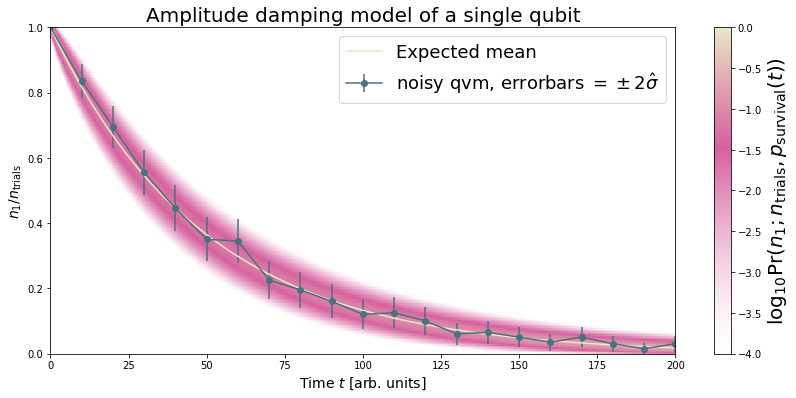

In [8]:
plt.figure(figsize=(14, 6))
plt.pcolor(dense_lengths, np.arange(trials+1)/trials, logpmf.T, cmap=cm, vmin=-4, vmax=logpmf.max())
plt.plot(dense_lengths, survival_probs, c=BEIGE, label="Expected mean")
plt.errorbar(lengths, results_damping[:,0], yerr=2*results_damping[:,1], c=DARK_TEAL, 
             label=r"noisy qvm, errorbars $ = \pm 2\hat{\sigma}$", marker="o")
cb = plt.colorbar()
cb.set_label(r"$\log_{10} \mathrm{Pr}(n_1; n_{\rm trials}, p_{\rm survival}(t))$", size=20)

plt.title("Amplitude damping model of a single qubit", size=20)
plt.xlabel(r"Time $t$ [arb. units]", size=14)
plt.ylabel(r"$n_1/n_{\rm trials}$", size=14)
plt.legend(loc="best", fontsize=18)
plt.xlim(*lengths[[0, -1]])
plt.ylim(0, 1)

# Example 2: dephased CZ-gate

Dephasing is usually characterized through a qubit's $T_2$ time. 
For a single qubit the dephasing Kraus operators are
$$
K_1(p) = \sqrt{1-p} I_2 \\
K_2(p) = \sqrt{p} \sigma_Z
$$
where $p = 1 - \exp(-T_2/T_{\rm gate})$ is the probability that the qubit is dephased over the time interval of interest, $I_2$ is the $2\times 2$-identity matrix and $\sigma_Z$ is the Pauli-Z operator.

For two qubits, we must construct a Kraus map that has *four* different outcomes:

1. No dephasing
2. Qubit 1 dephases
3. Qubit 2 dephases
4. Both dephase

The Kraus operators for this are given by
\begin{align}
K'_1(p,q) = K_1(p)\otimes K_1(q) \\
K'_2(p,q) = K_2(p)\otimes K_1(q) \\
K'_3(p,q) = K_1(p)\otimes K_2(q) \\
K'_4(p,q) = K_2(p)\otimes K_2(q) 
\end{align}
where we assumed a dephasing probability $p$ for the first qubit and $q$ for the second.

Dephasing is a *diagonal* error channel and the CZ gate is also diagonal, therefore we can get the combined map of dephasing and the CZ gate simply by composing $U_{\rm CZ}$ the unitary representation of CZ with each Kraus operator
\begin{align}
K^{\rm CZ}_1(p,q) = K_1(p)\otimes K_1(q)U_{\rm CZ} \\
K^{\rm CZ}_2(p,q) = K_2(p)\otimes K_1(q)U_{\rm CZ} \\
K^{\rm CZ}_3(p,q) = K_1(p)\otimes K_2(q)U_{\rm CZ} \\
K^{\rm CZ}_4(p,q) = K_2(p)\otimes K_2(q)U_{\rm CZ} 
\end{align}

**Note that this is not always accurate, because a CZ gate is often achieved through non-diagonal interaction Hamiltonians! However, for sufficiently small dephasing probabilities it should always provide a good starting point.**

In [9]:
def dephasing_kraus_map(p=.1):
    """
    Generate the Kraus operators corresponding to a dephasing channel.

    :params float p: The one-step dephasing probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return [np.sqrt(1-p)*np.eye(2), np.sqrt(p)*np.diag([1, -1])]

def tensor_kraus_maps(k1, k2):
    """
    Generate the Kraus map corresponding to the composition
    of two maps on different qubits.
    
    :param list k1: The Kraus operators for the first qubit.
    :param list k2: The Kraus operators for the second qubit.
    :return: A list of tensored Kraus operators.
    """
    return [np.kron(k1j, k2l) for k1j in k1 for k2l in k2]


In [10]:
%%time
# single step damping probabilities
ps = np.linspace(.001, .5, 200)

# number of program executions
trials = 500

results = []

for jj, p in enumerate(ps):

    corrupted_CZ = append_kraus_to_gate(
    tensor_kraus_maps(
        dephasing_kraus_map(p),
        dephasing_kraus_map(p)
    ), 
    np.diag([1, 1, 1, -1]))

    
    print("{}/{}, ".format(jj, len(ps)), end="")
    
    # make Bell-state
    p = Program(H(0), H(1), CZ(0,1), H(1))
    
    p.inst(MEASURE(0, [0]))
    p.inst(MEASURE(1, [1]))
    
    # overload identity I on qc 0
    p.define_noisy_gate("CZ", [0, 1], corrupted_CZ)
    cxn.random_seed = jj
    res = cxn.run(p, [0, 1], trials=trials)
    results.append(res)
    
results = np.array(results)

0/200, 1/200, 2/200, 3/200, 4/200, 5/200, 6/200, 7/200, 8/200, 9/200, 10/200, 11/200, 12/200, 13/200, 14/200, 15/200, 16/200, 17/200, 18/200, 19/200, 20/200, 21/200, 22/200, 23/200, 24/200, 25/200, 26/200, 27/200, 28/200, 29/200, 30/200, 31/200, 32/200, 33/200, 34/200, 35/200, 36/200, 37/200, 38/200, 39/200, 40/200, 41/200, 42/200, 43/200, 44/200, 45/200, 46/200, 47/200, 48/200, 49/200, 50/200, 51/200, 52/200, 53/200, 54/200, 55/200, 56/200, 57/200, 58/200, 59/200, 60/200, 61/200, 62/200, 63/200, 64/200, 65/200, 66/200, 67/200, 68/200, 69/200, 70/200, 71/200, 72/200, 73/200, 74/200, 75/200, 76/200, 77/200, 78/200, 79/200, 80/200, 81/200, 82/200, 83/200, 84/200, 85/200, 86/200, 87/200, 88/200, 89/200, 90/200, 91/200, 92/200, 93/200, 94/200, 95/200, 96/200, 97/200, 98/200, 99/200, 100/200, 101/200, 102/200, 103/200, 104/200, 105/200, 106/200, 107/200, 108/200, 109/200, 110/200, 111/200, 112/200, 113/200, 114/200, 115/200, 116/200, 117/200, 118/200, 119/200, 120/200, 121/200, 122/200, 123

In [11]:
Z1s = (2*results[:,:,0]-1.)
Z2s = (2*results[:,:,1]-1.)
Z1Z2s = Z1s * Z2s

Z1m = np.mean(Z1s, axis=1)
Z2m = np.mean(Z2s, axis=1)
Z1Z2m = np.mean(Z1Z2s, axis=1)

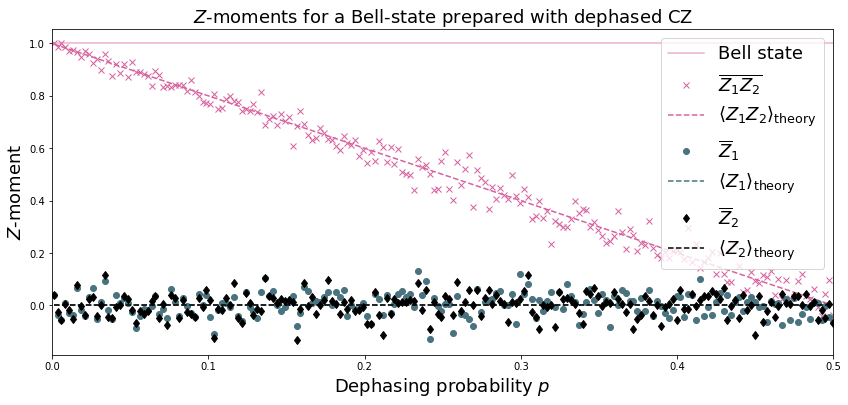

In [12]:
plt.figure(figsize=(14, 6))
plt.axhline(y=1.0, color=FUSCHIA, alpha=.5, label="Bell state")

plt.plot(ps, Z1Z2m, "x", c=FUSCHIA, label=r"$\overline{Z_1 Z_2}$")
plt.plot(ps, 1-2*ps, "--", c=FUSCHIA, label=r"$\langle Z_1 Z_2\rangle_{\rm theory}$")

plt.plot(ps, Z1m, "o", c=DARK_TEAL, label=r"$\overline{Z}_1$")
plt.plot(ps, 0*ps, "--", c=DARK_TEAL, label=r"$\langle Z_1\rangle_{\rm theory}$")

plt.plot(ps, Z2m, "d", c="k", label=r"$\overline{Z}_2$")
plt.plot(ps, 0*ps, "--", c="k", label=r"$\langle Z_2\rangle_{\rm theory}$")

plt.xlabel(r"Dephasing probability $p$", size=18)
plt.ylabel(r"$Z$-moment", size=18)
plt.title(r"$Z$-moments for a Bell-state prepared with dephased CZ", size=18)
plt.xlim(0, .5)
plt.legend(fontsize=18)

## Adding T1 and T2 type noise to all your gates 

Here we will provide some simple tools to define gate models for a full gate set (excluding $RZ(\theta)$ rotations, which can be executed without noise). 
We will again assume a very simple noise model in which the ideal gate is followed by the application of first dephasing and then damping noise.

In [13]:
def combine_kraus_maps(k1, k2):
    """
    Generate the Kraus map corresponding to the composition
    of two maps on the same qubits with k1 being applied to the state
    after k2.
    
    :param list k1: The list of Kraus operators that are applied second.
    :param list k2: The list of Kraus operators that are applied first.
    :return: A combinatorially generated list of composed Kraus operators.
    """
    return [np.dot(k1j, k2l) for k1j in k1 for k2l in k2]

def damping_after_dephasing(T1=30e-6, T2=30e-6, t_gate=50e-9):
    """
    Generate the Kraus map corresponding to the composition
    of a dephasing channel followed by an amplitude damping channel.
    
    :param float T1: The amplitude damping time
    :param float T2: The dephasing time
    :param float t_gate: The gate duration.
    :return: A list of Kraus operators.
    """
    return combine_kraus_maps(damping_channel(t_gate/T1), dephasing_kraus_map(t_gate/T2))

In [14]:
# Can only apply gate-noise to non-parametrized gates, so we need to define placeholders for RX(+/- pi/2)
# Feel free to modify these to experiment with other gate sets.
SINGLE_Q = {
    "X-PLUS-90": expm(-1j*np.pi/4 * np.array([[0, 1],
                                           [1, 0]])),
    "X-MINUS-90": expm(+1j*np.pi/4 * np.array([[0, 1],
                                            [1, 0]])),
    "H": np.array([[1., 1.],
                   [1., -1.]]) / np.sqrt(2),
    "I": np.eye(2)
}

TWO_Q = {
     "CZ": np.diag([1, 1, 1, -1]),
}

SWAP = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1]])


def make_noisy_gate_set(qubits, edges, T1s, T2s, gate_time_1q=50e-9, gate_time_2q=150e-9):
    """
    Generate the kraus maps for a full gate set.
    
    :param list|tuple qubits: The qubits in the gate set.
    :param list|tuple edges: A sequence of triplets (GATE, q0, q1) for which the
    two qubit gate `GATE q0 q1` exists as a natural member of the gate set.
    :param dict T1s: A dictionary mapping qubit id's to the respective T1 damping time
    :param dict T2s: A dictionary mapping qubit id's to the respective T2 dephasing time
    :param float gate_time_1q: The duration of a single qubit gate.
    :param float gate_time_2q: The duration of a two qubit gate.
    :return: A dictionary with keys (GATE, (target_1[, target_2)) and values given by 
    a list of Kraus operators for that gate.
    :rtype: dict
    """
    noisy_gate_set = {}
    for q in qubits:
        for g, m in SINGLE_Q.items():
            noisy_gate_set[(g, (q,))] = append_kraus_to_gate(
                damping_after_dephasing(T1s[q], T2s[q], gate_time_1q),
                m
            )
    for g, q1,q2 in edges:
        m = TWO_Q[g]
        
        # above matrix definition assumes q1 < q2
        if q2 < q1:
            m = SWAP.dot(m).dot(SWAP)
        k1 = damping_after_dephasing(T1s[q1], T2s[q1], gate_time_1q)
        k2 = damping_after_dephasing(T1s[q2], T2s[q2], gate_time_1q)
        k = tensor_kraus_maps(k1, k2)            
        noisy_gate_set[(g, (q1, q2))] = append_kraus_to_gate(k, m)
    return noisy_gate_set


def noisy_gate_set_header(noisy_gate_set, add_defgates=True):
    """
    Given a noisy gate set as generated by ``make_noisy_gate_set``, produce a 
    Quil program that consists purely of (noisy) gate definitions. 
    Optionally, the standard defgates are added, as well.
    
    :param dict noisy_gate_set: A dictionary with keys (GATE, (target_1[, target_2)) and values given by 
    a list of Kraus operators for that gate.
    :param bool add_defgates: If True, also generate the `DEFGATE` statements.
    :return: A Quil program with the DEFGATES and ``PRAGMA ADD-KRAUS`` statements.
    :rtype: Program
    """
    header = Program()
    if add_defgates:
        for name, matrix in SINGLE_Q.items():
            header.defgate(name, matrix)
        for name, matrix in TWO_Q.items():
            header.defgate(name, matrix)
    for (name, targets), kraus_ops in noisy_gate_set.items():
        header.define_noisy_gate(name, targets, kraus_ops)
    
    return header        

In [15]:
ngs = make_noisy_gate_set(
    [0, 1], 
    [
        ("CZ", 0, 1), 
        ("CZ", 1, 0)
    ], 
    {
        0: 35e-6, 
        1:33e-6
    }, 
    {
        0: 20e-6, 
        1: 25e-6
    }
)

### Example: Making a Bell state

In [16]:
p_bell = Program(H(0), H(1), CZ(0, 1), H(1))
p_bell_noisy = noisy_gate_set_header(ngs) + p_bell

In [17]:
print(p_bell_noisy)

DEFGATE X-PLUS-90:
    0.70710678118654757, -0.70710678118654746i
    -0.70710678118654746i, 0.70710678118654757

DEFGATE X-MINUS-90:
    0.70710678118654757, +0.70710678118654746i
    +0.70710678118654746i, 0.70710678118654757

DEFGATE I:
    1.0, 0
    0, 1.0

DEFGATE H:
    0.70710678118654746, 0.70710678118654746
    0.70710678118654746, -0.70710678118654746

DEFGATE CZ:
    1, 0, 0, 0
    0, 1, 0, 0
    0, 0, 1, 0
    0, 0, 0, -1

PRAGMA ADD-KRAUS I 0 "(0.99874921777190895 0.0 0.0 0.99803557050838621)"
PRAGMA ADD-KRAUS I 0 "(0.049999999999999996 0.0 0.0 -0.049964272950064739)"
PRAGMA ADD-KRAUS I 0 "(0.0 0.037749172176353749 0.0 0.0)"
PRAGMA ADD-KRAUS I 0 "(0.0 -0.0018898223650461359 0.0 0.0)"
PRAGMA ADD-KRAUS H 0 "(0.70622234459127664 0.70622234459127664 0.70571771977186448 -0.70571771977186448)"
PRAGMA ADD-KRAUS H 0 "(0.035355339059327369 0.035355339059327369 -0.035330076220046358 0.035330076220046358)"
PRAGMA ADD-KRAUS H 0 "(0.026692695630078277 -0.026692695630078277 0.0 0.0)"
P

In [18]:
for prog in (p_bell, p_bell_noisy):
    bell_result = cxn.run(prog.measure_all((0, 0), (1, 1)), [0, 1], trials=5000)
    bell_result = np.array(bell_result)

    Z0 = 2*bell_result[:,0] - 1.
    Z1 = 2*bell_result[:,1] - 1.
    Z0Z1 = Z0 * Z1

    print("<Z0>={}, <Z1>={}, <Z0Z1>={}".format(Z0.mean(), Z1.mean(), Z0Z1.mean()))



<Z0>=-0.0052, <Z1>=-0.0052, <Z0Z1>=1.0
<Z0>=0.0024, <Z1>=0.0, <Z0Z1>=0.9896


**We see that the $\langle Z_0Z_1 \rangle$ moment is slightly reduced for the noisy execution.**